# Hard Constraints vs Soft Constraints: Must Satisfy vs Penalties

This notebook demonstrates the difference between **hard constraints** (must be satisfied) and **soft constraints** (can be violated with penalties).

Understanding this distinction helps you:
- Model requirements that are absolute vs preferences
- Handle situations where strict constraints might make problems infeasible
- Balance competing requirements more flexibly
- Make better decisions when some constraints are more important than others


## Key Concepts

**Hard Constraints** are absolute requirements:
- Must be satisfied exactly
- Cannot be violated
- Examples: Legal requirements, safety limits, budget caps
- If violated, the solution is infeasible

**Soft Constraints** are preferences with penalties:
- Can be violated, but with a cost
- Represent preferences rather than requirements
- Examples: Target staffing levels, preferred delivery times
- Violation is allowed but penalized in the objective

**Critical insight**: Hard constraints define what's possible; soft constraints define what's preferred. Using soft constraints can make problems more solvable and solutions more practical.


## Scenario: Staffing with Hard and Soft Constraints

You need to schedule staff for a call center with:
- **Hard constraint**: Minimum 10 staff must be on duty at all times (safety/legal requirement)
- **Soft constraint**: Prefer to have 12-15 staff on duty (service quality target)
- **Hard constraint**: Budget cannot exceed $5,000 per day
- **Soft constraint**: Prefer to keep overtime below 20 hours (employee preference)

**Decision**: How many staff to schedule for each shift?


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Model with Hard Constraints Only

First, let's see what happens with only hard constraints:


In [3]:
# Problem setup
shifts = ['Morning', 'Afternoon', 'Evening', 'Night']
n_shifts = len(shifts)
regular_rate = 25  # $ per hour
overtime_rate = 37.5  # $ per hour

# HARD CONSTRAINTS (must be satisfied)
min_staffing_hard = 10  # Minimum staff required (legal/safety)
max_budget_hard = 5000  # Maximum budget (cannot exceed)

# Create model with hard constraints only
model_hard = LpProblem("Staffing_Hard_Only", LpMinimize)

# Decision variables
staff_hours = [LpVariable(f"staff_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_hours = [LpVariable(f"overtime_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]

# Objective: Minimize cost
total_cost = lpSum([regular_rate * staff_hours[i] + overtime_rate * overtime_hours[i] 
                    for i in range(n_shifts)])
model_hard += total_cost

# HARD CONSTRAINTS (must be satisfied)
for i in range(n_shifts):
    model_hard += staff_hours[i] + overtime_hours[i] >= min_staffing_hard, f"Min_Staffing_{shifts[i]}"

model_hard += total_cost <= max_budget_hard, "Budget_Limit"

# Solve
model_hard.solve()

# Get solution
solution_hard = {}
for i in range(n_shifts):
    total_hours = value(staff_hours[i]) + value(overtime_hours[i])
    cost = value(regular_rate * staff_hours[i] + overtime_rate * overtime_hours[i])
    solution_hard[shifts[i]] = {
        'Regular Hours': value(staff_hours[i]),
        'Overtime Hours': value(overtime_hours[i]),
        'Total Hours': total_hours,
        'Cost': cost
    }

total_cost_hard = value(model_hard.objective)
total_overtime_hard = sum([value(overtime_hours[i]) for i in range(n_shifts)])

hard_df = pd.DataFrame(solution_hard).T
print("SOLUTION: Hard Constraints Only")
print("=" * 70)
display(hard_df.round(2))
print(f"\nTotal Cost: ${total_cost_hard:,.2f}")
print(f"Total Overtime: {total_overtime_hard:.1f} hours")
print(f"Average Staffing: {hard_df['Total Hours'].mean():.1f} hours per shift")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e3f78a247cfb485c86afead59b8d7de4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/e3f78a247cfb485c86afead59b8d7de4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 35 RHS
At line 41 BOUNDS
At line 42 ENDATA
Problem MODEL has 5 rows, 8 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 5 (0) rows, 8 (0) columns and 16 (0) elements
Perturbing problem by 0.001% of 37.5 - largest nonzero change 0.00017908774 ( 0.00047756732%) - largest zero change 0
0  Obj 0 Primal inf 40 (4)
4  Obj 1000.0043
Optimal - objective value 1000
Optimal objective 1000 - 4 iterations time 0.0

,Regular Hours,Overtime Hours,Total Hours,Cost
Morning,10.0,0.0,10.0,250.0
Afternoon,10.0,0.0,10.0,250.0
Evening,10.0,0.0,10.0,250.0
Night,10.0,0.0,10.0,250.0



Total Cost: $1,000.00
Total Overtime: 0.0 hours
Average Staffing: 10.0 hours per shift


## Step 4: Model with Hard + Soft Constraints

Now let's add soft constraints with penalties for violation:


In [4]:
# SOFT CONSTRAINT TARGETS (preferences, not requirements)
target_staffing = 13  # Prefer 13 staff per shift
target_overtime = 15  # Prefer max 15 hours overtime
penalty_per_staff_short = 10  # Penalty per staff hour below target
penalty_per_overtime = 20  # Penalty per overtime hour above target

# Create model with hard + soft constraints
model_soft = LpProblem("Staffing_Hard_Soft", LpMinimize)

# Decision variables
staff_hours2 = [LpVariable(f"staff2_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_hours2 = [LpVariable(f"overtime2_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]

# Variables for soft constraint violations
staff_shortfall = [LpVariable(f"shortfall_{i}", lowBound=0, cat='Continuous') for i in range(n_shifts)]
overtime_excess = LpVariable("overtime_excess", lowBound=0, cat='Continuous')

# Objective: Minimize cost + penalties for soft constraint violations
total_cost2 = lpSum([regular_rate * staff_hours2[i] + overtime_rate * overtime_hours2[i] 
                     for i in range(n_shifts)])
penalty_cost = lpSum([penalty_per_staff_short * staff_shortfall[i] for i in range(n_shifts)]) + \
               penalty_per_overtime * overtime_excess
model_soft += total_cost2 + penalty_cost

# HARD CONSTRAINTS (must be satisfied)
for i in range(n_shifts):
    model_soft += staff_hours2[i] + overtime_hours2[i] >= min_staffing_hard, f"Min_Staffing_{shifts[i]}"
model_soft += total_cost2 <= max_budget_hard, "Budget_Limit"

# SOFT CONSTRAINTS (preferences with penalties)
for i in range(n_shifts):
    total_hours = staff_hours2[i] + overtime_hours2[i]
    # If below target, shortfall is positive
    model_soft += staff_shortfall[i] >= target_staffing - total_hours, f"Staff_Shortfall_{shifts[i]}"

total_overtime_var = lpSum(overtime_hours2)
model_soft += overtime_excess >= total_overtime_var - target_overtime, "Overtime_Excess"

# Solve
model_soft.solve()

# Get solution
solution_soft = {}
for i in range(n_shifts):
    total_hours = value(staff_hours2[i]) + value(overtime_hours2[i])
    cost = value(regular_rate * staff_hours2[i] + overtime_rate * overtime_hours2[i])
    shortfall = value(staff_shortfall[i])
    solution_soft[shifts[i]] = {
        'Regular Hours': value(staff_hours2[i]),
        'Overtime Hours': value(overtime_hours2[i]),
        'Total Hours': total_hours,
        'Cost': cost,
        'Shortfall from Target': shortfall
    }

total_cost_soft = value(total_cost2)
penalty_soft = value(penalty_cost)
total_overtime_soft = sum([value(overtime_hours2[i]) for i in range(n_shifts)])
overtime_excess_val = value(overtime_excess)

soft_df = pd.DataFrame(solution_soft).T
print("SOLUTION: Hard + Soft Constraints")
print("=" * 70)
display(soft_df.round(2))
print(f"\nTotal Cost: ${total_cost_soft:,.2f}")
print(f"Penalty Cost: ${penalty_soft:,.2f}")
print(f"Total Cost + Penalties: ${total_cost_soft + penalty_soft:,.2f}")
print(f"Total Overtime: {total_overtime_soft:.1f} hours")
print(f"Overtime Excess: {overtime_excess_val:.1f} hours")
print(f"Average Staffing: {soft_df['Total Hours'].mean():.1f} hours per shift")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ee907301053b4530925af12f78c3bbbb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ee907301053b4530925af12f78c3bbbb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 62 RHS
At line 73 BOUNDS
At line 74 ENDATA
Problem MODEL has 10 rows, 13 columns and 33 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 10 (0) rows, 13 (0) columns and 33 (0) elements
0  Obj 0 Primal inf 91.999999 (8)
8  Obj 1120
Optimal - objective value 1120
Optimal objective 1120 - 8 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock secon

,Regular Hours,Overtime Hours,Total Hours,Cost,Shortfall from Target
Morning,10.0,0.0,10.0,250.0,3.0
Afternoon,10.0,0.0,10.0,250.0,3.0
Evening,10.0,0.0,10.0,250.0,3.0
Night,10.0,0.0,10.0,250.0,3.0



Total Cost: $1,000.00
Penalty Cost: $120.00
Total Cost + Penalties: $1,120.00
Total Overtime: 0.0 hours
Overtime Excess: 0.0 hours
Average Staffing: 10.0 hours per shift


In [5]:
comparison = pd.DataFrame({
    'Approach': ['Hard Constraints Only', 'Hard + Soft Constraints'],
    'Total Cost ($)': [total_cost_hard, total_cost_soft],
    'Penalty Cost ($)': [0, penalty_soft],
    'Total Cost + Penalties ($)': [total_cost_hard, total_cost_soft + penalty_soft],
    'Total Overtime (hours)': [total_overtime_hard, total_overtime_soft],
    'Avg Staffing per Shift': [hard_df['Total Hours'].mean(), soft_df['Total Hours'].mean()],
    'Target Staffing Met': ['N/A', 'Yes' if soft_df['Shortfall from Target'].sum() == 0 else 'No']
})

print("COMPARISON: Hard-Only vs Hard+Soft")
print("=" * 70)
display(comparison.round(2))

print("\nKey Differences:")
print(f"  - Hard-only: Focuses only on satisfying minimum requirements")
print(f"  - Hard+Soft: Also tries to meet preferred targets (with penalties if not)")
print(f"  - Soft constraints allow more flexible solutions that balance multiple preferences")


COMPARISON: Hard-Only vs Hard+Soft


,Approach,Total Cost ($),Penalty Cost ($),Total Cost + Penalties ($),Total Overtime (hours),Avg Staffing per Shift,Target Staffing Met
0,Hard Constraints Only,1000.0,0.0,1000.0,0.0,10.0,N/A
1,Hard + Soft Constraints,1000.0,120.0,1120.0,0.0,10.0,No



Key Differences:
  - Hard-only: Focuses only on satisfying minimum requirements
  - Hard+Soft: Also tries to meet preferred targets (with penalties if not)
  - Soft constraints allow more flexible solutions that balance multiple preferences


## Step 6: Visualize the Difference

Let's visualize how hard and soft constraints work differently:


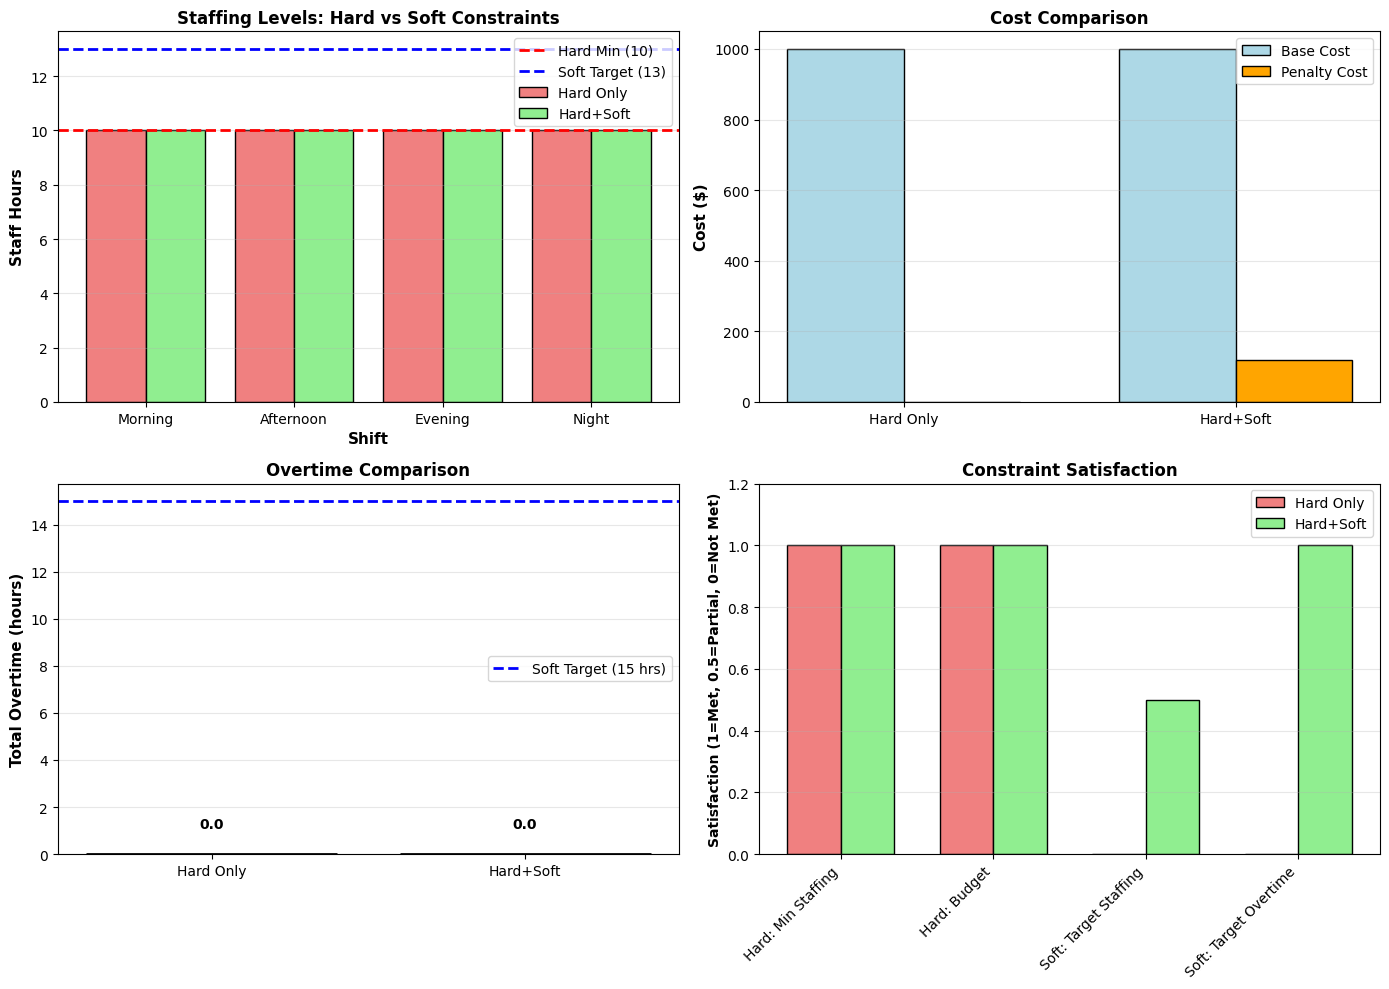


Key Insights:
  - Hard constraints MUST be satisfied (red dashed line)
  - Soft constraints are PREFERENCES with penalties (blue dashed line)
  - Hard+Soft approach balances multiple preferences while respecting hard limits
  - Soft constraints make solutions more flexible and practical


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Staffing levels comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(shifts))
hard_staffing = [hard_df.loc[s, 'Total Hours'] for s in shifts]
soft_staffing = [soft_df.loc[s, 'Total Hours'] for s in shifts]

ax1.bar(x_pos - 0.2, hard_staffing, 0.4, label='Hard Only', color='lightcoral', edgecolor='black')
ax1.bar(x_pos + 0.2, soft_staffing, 0.4, label='Hard+Soft', color='lightgreen', edgecolor='black')
ax1.axhline(y=min_staffing_hard, color='red', linestyle='--', linewidth=2, label=f'Hard Min ({min_staffing_hard})')
ax1.axhline(y=target_staffing, color='blue', linestyle='--', linewidth=2, label=f'Soft Target ({target_staffing})')
ax1.set_xlabel('Shift', fontsize=11, fontweight='bold')
ax1.set_ylabel('Staff Hours', fontsize=11, fontweight='bold')
ax1.set_title('Staffing Levels: Hard vs Soft Constraints', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(shifts)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Cost breakdown
ax2 = axes[0, 1]
approaches = ['Hard Only', 'Hard+Soft']
costs_plot = [total_cost_hard, total_cost_soft]
penalties_plot = [0, penalty_soft]
x = np.arange(len(approaches))
width = 0.35

ax2.bar(x - width/2, costs_plot, width, label='Base Cost', color='lightblue', edgecolor='black')
ax2.bar(x + width/2, penalties_plot, width, label='Penalty Cost', color='orange', edgecolor='black')
ax2.set_ylabel('Cost ($)', fontsize=11, fontweight='bold')
ax2.set_title('Cost Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(approaches)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Overtime comparison
ax3 = axes[1, 0]
overtime_data = [total_overtime_hard, total_overtime_soft]
bars3 = ax3.bar(approaches, overtime_data, color=['lightcoral', 'lightgreen'], edgecolor='black', linewidth=2)
ax3.axhline(y=target_overtime, color='blue', linestyle='--', linewidth=2, label=f'Soft Target ({target_overtime} hrs)')
ax3.set_ylabel('Total Overtime (hours)', fontsize=11, fontweight='bold')
ax3.set_title('Overtime Comparison', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars3, overtime_data):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Constraint satisfaction
ax4 = axes[1, 1]
constraint_types = ['Hard: Min Staffing', 'Hard: Budget', 'Soft: Target Staffing', 'Soft: Target Overtime']
hard_only_satisfaction = [1, 1, 0, 0]  # Hard constraints met, soft not considered
hard_soft_satisfaction = [1, 1, 1 if soft_df['Shortfall from Target'].sum() == 0 else 0.5, 
                          1 if overtime_excess_val == 0 else 0.5]

x_const = np.arange(len(constraint_types))
width_const = 0.35
ax4.bar(x_const - width_const/2, hard_only_satisfaction, width_const, label='Hard Only', 
        color='lightcoral', edgecolor='black')
ax4.bar(x_const + width_const/2, hard_soft_satisfaction, width_const, label='Hard+Soft', 
        color='lightgreen', edgecolor='black')
ax4.set_ylabel('Satisfaction (1=Met, 0.5=Partial, 0=Not Met)', fontsize=10, fontweight='bold')
ax4.set_title('Constraint Satisfaction', fontsize=12, fontweight='bold')
ax4.set_xticks(x_const)
ax4.set_xticklabels(constraint_types, rotation=45, ha='right')
ax4.legend()
ax4.set_ylim([0, 1.2])
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Hard constraints MUST be satisfied (red dashed line)")
print("  - Soft constraints are PREFERENCES with penalties (blue dashed line)")
print("  - Hard+Soft approach balances multiple preferences while respecting hard limits")
print("  - Soft constraints make solutions more flexible and practical")


## Summary: Hard vs Soft Constraints

**Hard Constraints** (must satisfy):
- Absolute requirements that cannot be violated
- Examples: Legal requirements, safety limits, budget caps
- If violated, solution is infeasible
- Define what's possible

**Soft Constraints** (preferences with penalties):
- Preferences that can be violated with a cost
- Examples: Target staffing levels, preferred delivery times
- Violation is allowed but penalized
- Define what's preferred

**When to Use Each**:
- **Use hard constraints** for:
  - Legal/regulatory requirements
  - Safety limits
  - Absolute budget caps
  - Non-negotiable requirements
  
- **Use soft constraints** for:
  - Quality targets
  - Employee preferences
  - Service level goals
  - Flexible requirements

**Practical Implication**:
- Hard constraints define feasibility
- Soft constraints allow flexible optimization
- Combining both creates more practical and balanced solutions
